In [10]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import sys
import pandas as pd
import seaborn as sns
import xarray as xr
import datetime as datetime

#sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
sys.path.append('/home/sachin/miniconda3/envs/server_env')
from esn_dts_openloop import ESN, Tikhonov

In [11]:
#REPPU otuputs
#path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pwbig5min.dat'#Mac
#path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/REPPU/200/pbig5min.dat' #Ubuntu
path = r'/home/sachin/research/data/REPPU/pbig5min.dat' #Server

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [12]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [13]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset>
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 53.1 54.36 55.62 56.89 ... 85.91 87.18 88.44 89.7
  * lon        (lon) float64 1.6 6.106 10.61 15.12 ... 344.1 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71

In [14]:
#open the omni data and merge it with the REPPU data
#omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'
omni_mhd_path = r'/home/ryuho/Documents/reddy/research/SMRAI/Data/OMNI/'

omni_df = pd.read_csv('omni_mhd_5min.csv')
#omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset>
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential       (dt, lat, lon) float32 0.6909 0.507 0.3146 ... -22.67 -22.71
    BY_GSE          (dt) float64 4.72 4.35 4.61 4.65 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 6.24 6.55 6.56 6.89 ... -0.53 -0.74 -4.03 -4.71
    flow_speed      (dt) float64 344.0 344.0 345.0 344.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 12.11 11.44 12.65 12.63 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 0.253 0.2497 0.2465 ... 0.2778 0.2744 0.271

In [15]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [16]:
#training data
X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#test data
X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [17]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons
density = 0.1 #connection density
input_scaling = 0.1 #scaling of input weights
spectral_radius = 0.99 #spectral radius of the recurrent matrix
beta = 1e-3 #regularization factor

In [18]:
model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=density, input_scale=input_scaling, rho=spectral_radius)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=beta)
model.train(X_train, y_train, optimizer)

array([[  59.17415047, -401.45096267,  268.85373093, ..., -573.47927344,
        -652.62033026,  792.45032891],
       [  57.25215   , -401.58119387,  267.8143115 , ..., -573.25943367,
        -651.452687  ,  789.86623521],
       [  57.3100277 , -401.79994819,  267.486732  , ..., -573.85446444,
        -654.04199479,  791.32642952],
       ...,
       [  64.45981969, -393.85660783,  271.32278816, ..., -572.88814219,
        -642.60283537,  774.65197025],
       [  64.94139628, -394.19668174,  272.00526602, ..., -573.68505293,
        -642.05097345,  774.81321321],
       [  64.78020013, -392.35193225,  270.91919597, ..., -571.79638716,
        -640.3147514 ,  772.04195986]])

In [19]:
#save model
with open('SMRAI2_current_SR.pkl', 'wb') as f:
    pickle.dump(model, f)

#load model
#with open('SMRAI2_current_SR.pkl', 'rb') as f:
#    model = pickle.load(f)

In [25]:
#make prediction on the test data
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(-1, 30, 80) #reshape the prediction to lat, lon

In [26]:
#Create prediction dataset and import dt, lat, and lon from test set (same size)
ds_pred = xr.Dataset({'potential': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add potential and units
ds_pred['potential'].attrs['units'] = 'kV'
ds_pred = ds_pred.merge(ds_test.drop_vars('potential'))

#calculate RMSE across all lat, lon
ds_pred['RMSE'] = np.sqrt((ds_pred['potential'] - ds_test['potential'])**2)
ds_pred['RMSE'].attrs['units'] = 'kV'

#convert long to mlt
ds_pred['lon'] = np.mod(ds_pred['lon'] / 15, 24) #convert lon to mlt
ds_pred

#export predictions
#ds_pred.to_netcdf('SMRAI2_potential_predictions.nc')

<xarray.Dataset>
Dimensions:         (dt: 5582, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 2022-07-11T15:05:00 ... 2022-07-31T23...
  * lat             (lat) float64 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon             (lon) float64 0.1067 0.4071 0.7075 ... 23.24 23.54 23.84
Data variables:
    potential       (dt, lat, lon) float64 3.985 3.499 2.989 ... -24.35 -24.38
    BY_GSE          (dt) float64 7.96 8.2 8.13 8.94 ... -9.29 -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 -3.35 -2.99 -2.57 -2.31 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 340.0 341.0 337.0 336.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 9.32 9.77 10.02 9.5 ... 7.12 8.03 7.08 6.84
    tilt_angle      (dt) float64 0.5268 0.5285 0.5301 ... 0.2778 0.2744 0.271
    RMSE            (dt, lat, lon) float64 0.4908 0.5585 0.6185 ... 1.678 1.67

In [27]:
np.mean(ds_pred['RMSE'].values)

4.386572219054434

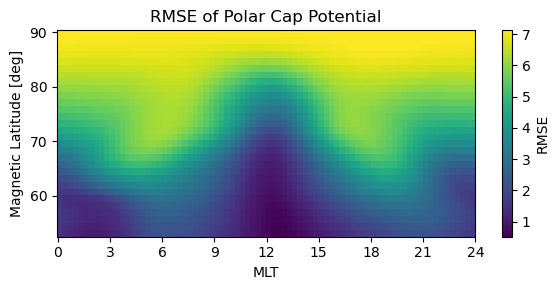

In [23]:
fig = plt.figure(figsize=(6,3))

#plot RMSE as radar plot
cbar = ds_pred['RMSE'].mean('dt').plot()
plt.title('RMSE of Polar Cap Potential')
plt.ylabel('Magnetic Latitude [deg]')
plt.xticks(np.arange(0, 25, 3))
plt.xlabel('MLT')

plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/global-rmse_SMRAI2.png', dpi=300)

In [24]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-12 is worst


#2022-07-31 is okay
#2022-07-25 is okay

#2022-07-29 is best
#2022-07-30 is best
date = '2022-07-31'

#date_range = pd.date_range('2022-07-29', '2022-07-30', freq = 'm')

#extract SYM-H values
symh = ds_pred['Kp'].sel(dt=date)

symh_hourly = pd.DataFrame(symh.values, columns=['Kp'])
symh_hourly['dt'] = symh['dt'].values
symh_hourly.set_index('dt', inplace=True)
symh_hourly = symh_hourly.resample('3h').mean()

fig, ax = plt.subplots(figsize=(6, 4))
ds_pred['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (Prediction)', color='#648FFF')
ds_test['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (G. Truth)', color='#FFB000')

rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  

skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)


'''
i = plt.annotate(f'RMSE = {rmse:.2f} kV', xy=(0.75, 0.05), xycoords='axes fraction')
j = plt.annotate(f'R = {r:.2f}', xy=(0.75, 0.12), xycoords='axes fraction')
k = plt.annotate(f'Skill = {skill_val:.2f}', xy=(0.75, 0.19), xycoords='axes fraction')

t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
i.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
j.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))'''

annotations = [
    (f'RMSE = {rmse:.1f} kV', (0.75, 0.05)),
    (f'R = {r:.2f}', (0.75, 0.15)),
    (f'Skill = {skill_val:.2f}', (0.75, 0.25))
]

for annotation, position in annotations:
    annot = plt.annotate(annotation, xy=position, xycoords='axes fraction')
    annot.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#add SYM-H label
#plt.annotate('Kp:', xy=(-0.04, -0.25), xycoords='axes fraction'
#            , ha='center', va='center', color='k')
#add sym_hourly values beneath the x ticks
for i, val in enumerate(symh_hourly['Kp'].values):
    plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

#remove top and right spines


plt.legend()
plt.title(f'Polar Cap Potential \n{date}',pad=8)
plt.xlabel(' ')
phi = r'$\mathrm{\phi}$'
plt.ylabel(f'Potential ({phi}) [kV]')
plt.grid(True)
plt.tight_layout()
#plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/rmse.png', dpi=300)

KeyError: 'Kp'

In [ ]:
#correlation between potential and Kp
pot = ds_test['potential'].mean(['lat', 'lon']).values
kp = ds_test['Kp'].values
r = np.corrcoef(pot, kp)[0, 1]
r

: 

In [ ]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
#r_list = []
#skill_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
    #r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]
    #skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)
    rmse_list.append(rmse)
    #r_list.append(r)
    #skill_list.append(skill_val)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
#rmse_df['Kp'] = ds_test['Kp'].values
rmse_df

: 

In [ ]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

: 

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=rmse_df, x='date', y='Kp', ax=ax)

: 

In [ ]:
#plot the RMSE
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=rmse_df, x='date', y='RMSE', ax=ax)
plt.ylabel('RMSE [kV]')
#plt.xticks(np.arange(0, 25, 3))
#plt.xlabel('UTC')

: 

In [ ]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

: 

In [ ]:
# Define the date
date = "2022-07-31"

# Extract true and predicted values
pot_true = ds_test['potential'].sel(dt=date).values[0]
pot_pred = ds_pred['potential'].sel(dt=date).values[0]

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


: 

In [ ]:

# Select the date
date = "2022-07-31"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.18
t_pad = 10
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['potential'].sel(dt=date).values[i]
    pot_pred = ds_pred['potential'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)',pad=t_pad)
    axs[0].grid(True, alpha=0.7)
    plt.colorbar(c_true, ax=axs[0], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PuOr', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[1].set_title('Predicted Potential \n (SMRAI)',pad=t_pad)
    axs[1].grid(True, alpha=0.7)
    plt.colorbar(c_pred, ax=axs[1], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='bwr', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT \nMidnight", "3", "6", "9", "Midday \n12", "15", "18"])
    axs[2].set_title(f'Difference \n(True - Predicted)',pad=t_pad)
    axs[2].grid(True, alpha=0.7)
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.subplots_adjust(wspace=-0.8)  # Adjust horizontal space between subplots

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.45, -0.7), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break

: 